In [1]:
#Dedicated cell for import/libraries... should be able to hide this later
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sn
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC 
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from xgboost import plot_importance
import csv
import math
import itertools
# For producing decision tree diagrams.
from IPython.display import Image
import pydotplus
import graphviz
from io import StringIO
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data

In [2]:
df = pd.read_csv("DailyVars4.csv")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4789 entries, 0 to 4788
Data columns (total 43 columns):
Dates              4789 non-null object
RLG Index          4789 non-null float64
RLV Index          4789 non-null float64
RTY Index          4789 non-null float64
RIY Index          4789 non-null float64
DXY Curncy         4789 non-null float64
USGG10YR Index     4789 non-null float64
USGG2YR Index      4789 non-null float64
RR10CUS Index      4789 non-null float64
USGGBE10 Index     4789 non-null float64
VIX Index          4789 non-null float64
CSI BARC Index     4789 non-null float64
CSI BBB Index      4789 non-null float64
CSI A Index        4789 non-null float64
SHSZ300 Index      4789 non-null float64
MSER Index         4789 non-null float64
XAU Curncy         4789 non-null float64
CL1 COMB Comdty    4789 non-null float64
BCOMINTR Index     4789 non-null float64
SKEW Index         4789 non-null float64
CSIIUSD Index      4789 non-null float64
CSIIGL Index       4789 non-null 

In [3]:
df.tail()

,Dates,RLG Index,RLV Index,RTY Index,RIY Index,DXY Curncy,USGG10YR Index,USGG2YR Index,RR10CUS Index,USGGBE10 Index,...,10yrYieldMom,2yrYieldMom,RRchgMom,BE10yrMom,CreditMom,ChinaMom,EuroMom,GoldMom,OilMom,MetalMom
4784,12/31/2021,-0.079312,-0.017239,-0.086657,-0.050081,-0.005054,0.0658,0.1196,0.07,0.1218,...,0.044036,0.061480,0.043905,0.081011,-0.108317,-33.409143,29.613714,20.641810,4.080571,12.142612
4785,1/3/2022,-0.079533,-0.013115,-0.106946,-0.048314,0.000999,0.2850,0.1805,0.17,0.2048,...,0.065769,0.067910,0.048571,0.095430,-0.096921,-33.209143,29.033524,16.948190,3.726381,10.940277
4786,1/4/2022,-0.104817,-0.032423,-0.122459,-0.070449,-0.000685,0.2131,0.1287,0.08,0.1492,...,0.084598,0.061670,0.046476,0.101349,-0.085714,-41.644762,28.101619,17.141238,3.417429,10.798737
4787,1/5/2022,-0.063685,-0.023433,-0.087347,-0.044343,-0.002055,0.2319,0.1364,0.04,0.0293,...,0.102813,0.068313,0.034667,0.088200,-0.077683,-43.550095,30.399905,16.774381,3.277333,10.855623
4788,1/6/2022,-0.060296,-0.023404,-0.086841,-0.042526,0.004442,0.1999,0.1841,-0.01,-0.0551,...,0.133573,0.088153,0.034762,0.066767,-0.067937,-59.259905,30.644952,11.737619,3.418476,10.464088


In [4]:
# transform absolute index level to weekly changes
df['Dates'] = pd.to_datetime(df['Dates'])

In [5]:
df.rename(columns={'RLG Index':'GrowthReturn','RLV Index':'ValueReturn','RTY Index':'SmallReturn',
                   'RIY Index':'LargeReturn','DXY Curncy':'USDReturn', 'USGG10YR Index':'US10yrChg',
                   'USGG2YR Index':'US2yrChg', 'RR10CUS Index':'RealRateChg', 
                   'USGGBE10 Index':'BreakevenChg', 'VIX Index':'VIXreturn', 
                   'CSI BARC Index':'USHYSpreadChg','CSI BBB Index':'USBBBSpreadChg',
                   'CSI A Index':'USASpreadChg', 'SHSZ300 Index':'SHSZ300Return',
                   'MSER Index':'EuroMktReturn', 'XAU Curncy':'GoldRet', 'CL1 COMB Comdty':'OilRet',
                   'BCOMINTR Index':'MetalRet', 'SKEW Index':'SkewChg', 
                   'CSIIUSD Index':'USInflSurprise', 'CSIIGL Index':'GblInflSurprise', 'XNDX Index':'NasdaqRet', 
                   'SPX Index':'SPXRet', 'XNDXMom':'NasdaqMom', 'DXYMom':'USDMom'},
          inplace=True)
df.describe()

,GrowthReturn,ValueReturn,SmallReturn,LargeReturn,USDReturn,US10yrChg,US2yrChg,RealRateChg,BreakevenChg,VIXreturn,...,10yrYieldMom,2yrYieldMom,RRchgMom,BE10yrMom,CreditMom,ChinaMom,EuroMom,GoldMom,OilMom,MetalMom
count,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,...,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000
mean,0.010024,0.006739,0.009340,0.008418,-0.000095,-0.010474,-0.004605,-0.025377,0.003762,0.029676,...,-0.004173,-0.001799,-0.010126,0.001533,-0.004162,6.339028,1.222987,2.449961,0.074405,0.435262
std,0.046893,0.048093,0.061401,0.046001,0.021828,0.238520,0.196222,0.287996,0.164995,0.309719,...,0.105426,0.086375,0.128871,0.073636,0.167255,113.662585,23.283658,25.105260,2.997395,8.512987
min,-0.314014,-0.380202,-0.411258,-0.337932,-0.096873,-1.392600,-1.119600,-1.450000,-1.083000,-0.562463,...,-0.605542,-0.543841,-0.989429,-0.508965,-0.964825,-690.577048,-234.613429,-153.632762,-17.394667,-43.203981
25%,-0.012120,-0.012786,-0.022000,-0.011291,-0.013454,-0.148000,-0.078900,-0.170000,-0.077500,-0.128896,...,-0.068375,-0.037004,-0.079429,-0.034046,-0.068603,-37.626095,-9.610762,-9.921714,-1.564571,-3.782930
50%,0.015447,0.012587,0.014917,0.014063,0.000000,-0.014700,0.004100,-0.020000,0.004600,-0.023904,...,-0.004523,0.000442,-0.005714,0.002217,-0.016159,7.462476,5.202286,2.950476,0.431905,0.722524
75%,0.036701,0.032101,0.043884,0.033772,0.012993,0.133700,0.095800,0.150000,0.093200,0.110169,...,0.063311,0.042579,0.068000,0.041470,0.046381,57.300571,15.943333,16.125333,1.939333,4.705139
max,0.261441,0.270442,0.305294,0.253577,0.123283,0.924800,0.774700,0.930000,1.020300,5.044591,...,0.353107,0.362778,0.414476,0.382708,1.694698,491.822571,87.015524,117.794286,10.348286,36.636648


<Figure size 2160x2160 with 0 Axes>

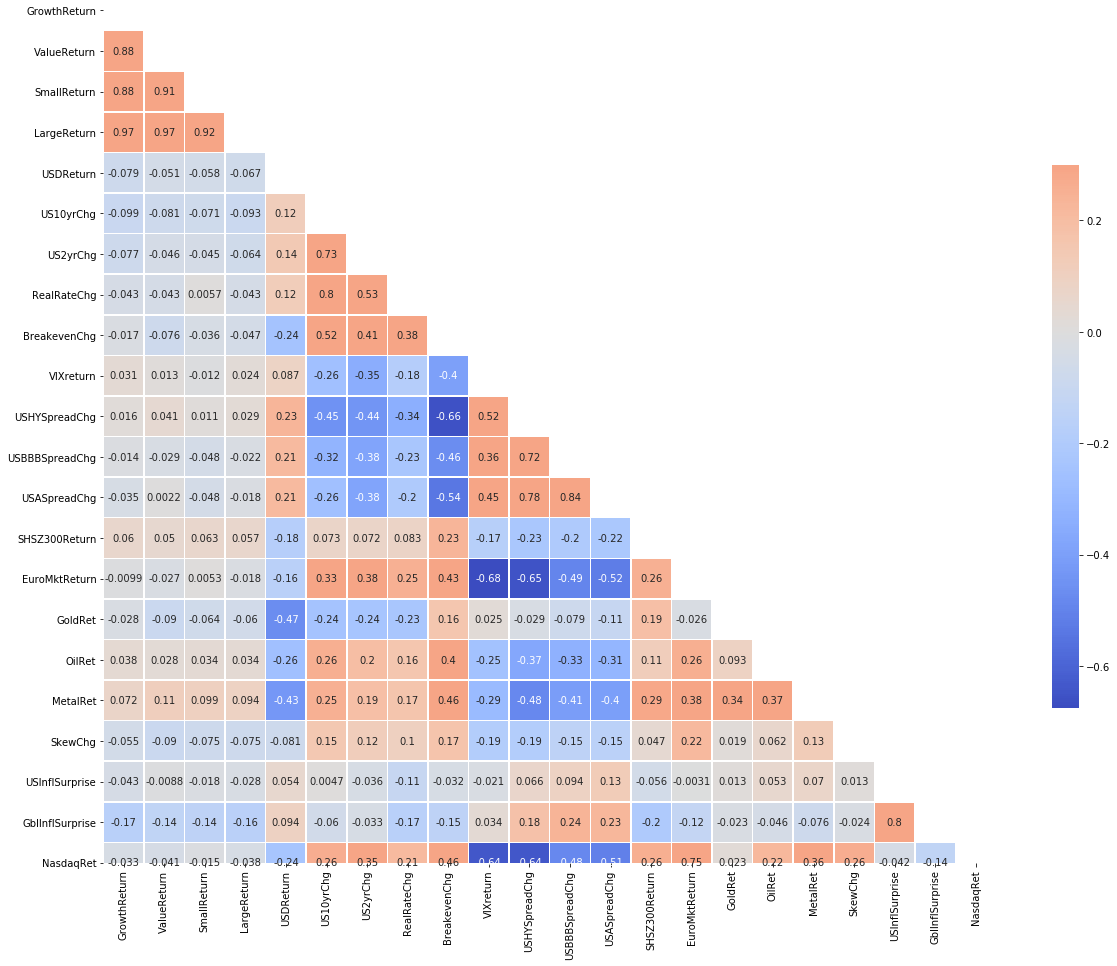

In [11]:
#Explore correlations 
plt.figure(figsize=(30,30))
corr = df.iloc[:, :23].corr() 
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap='coolwarm'
#cmap="warm"
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

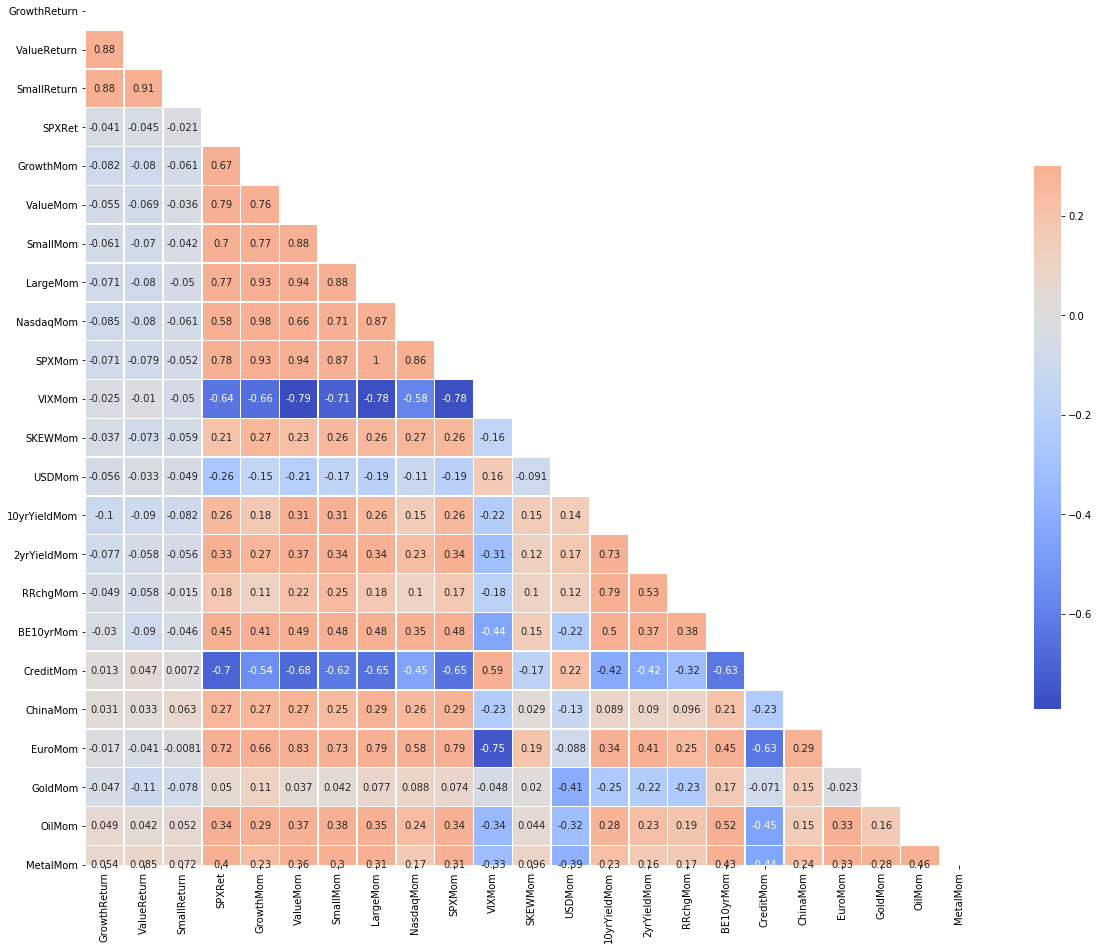

In [13]:
corr = pd.concat([df.iloc[:,:4], df.iloc[:, 23:]], axis=1).corr() 
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap='coolwarm'
#cmap="warm"
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Observations:

Macro variables that are highly correlated to the 4 target variables:

Negatively correlated:

- VIX index return
- US HY spread change
- US BBB spread change
- US A spread change
- USD return

Positive correlated:

- Europe Dev Market return
- SHSZ300 index return
- US 10yr breakeven
- US 2yr yield, US 10yr yield

Low correlation:

- QoQ GDP change
- 2yr vs 10yr spread change
- 10yr real rate

### Transformation and removal

**Convert Target variables to categorical based on the strongest return:**

1. Growth outperform
2. Value outperform
3. Small-cap outperform
4. Large-cap outperform

**Feature variable transformation:**

- take average of the US HY, BBB and A variables since they are highly correlated to each other.

Consider to remove the variables that have low correlation with the target variables. While they may not produce significant info gain, they may cause multi-collinearity as they have high correlation with other feature variables.

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


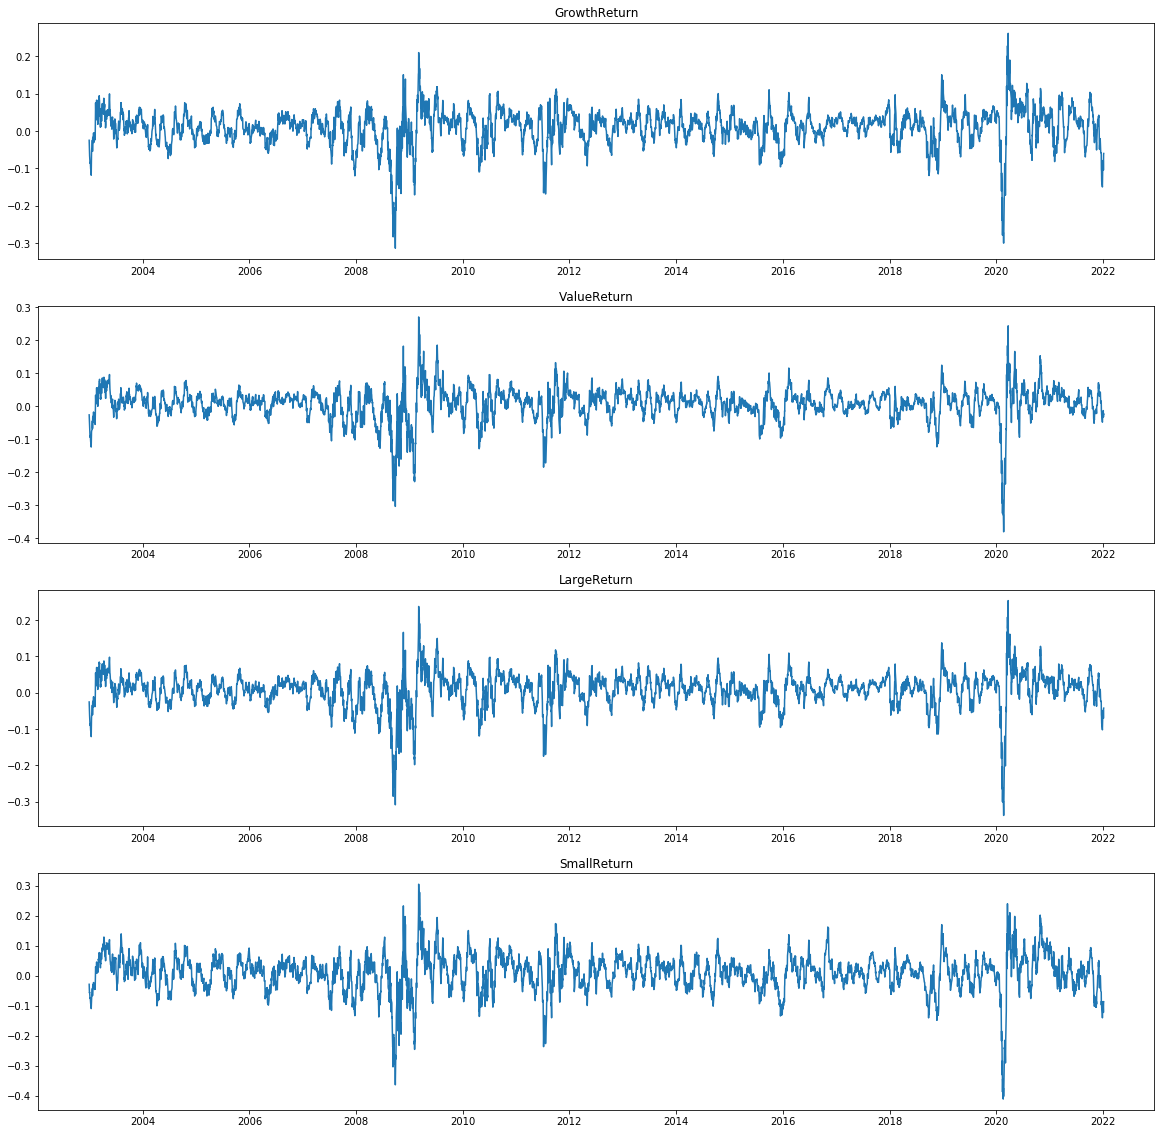

In [14]:
Target_names = ['GrowthReturn', 'ValueReturn', 'LargeReturn', 'SmallReturn']
fig, axs = plt.subplots(len(Target_names), 1, figsize=(20,20))
axs = axs.ravel()
for i in range(len(Target_names)):
    axs[i].plot(df['Dates'], df[Target_names[i]])
    axs[i].set_title(Target_names[i])

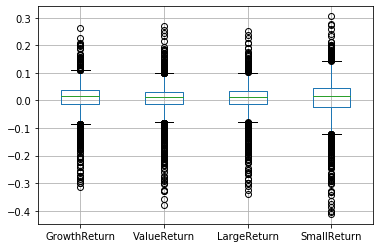

In [15]:
df[Target_names].boxplot()
plt.show()

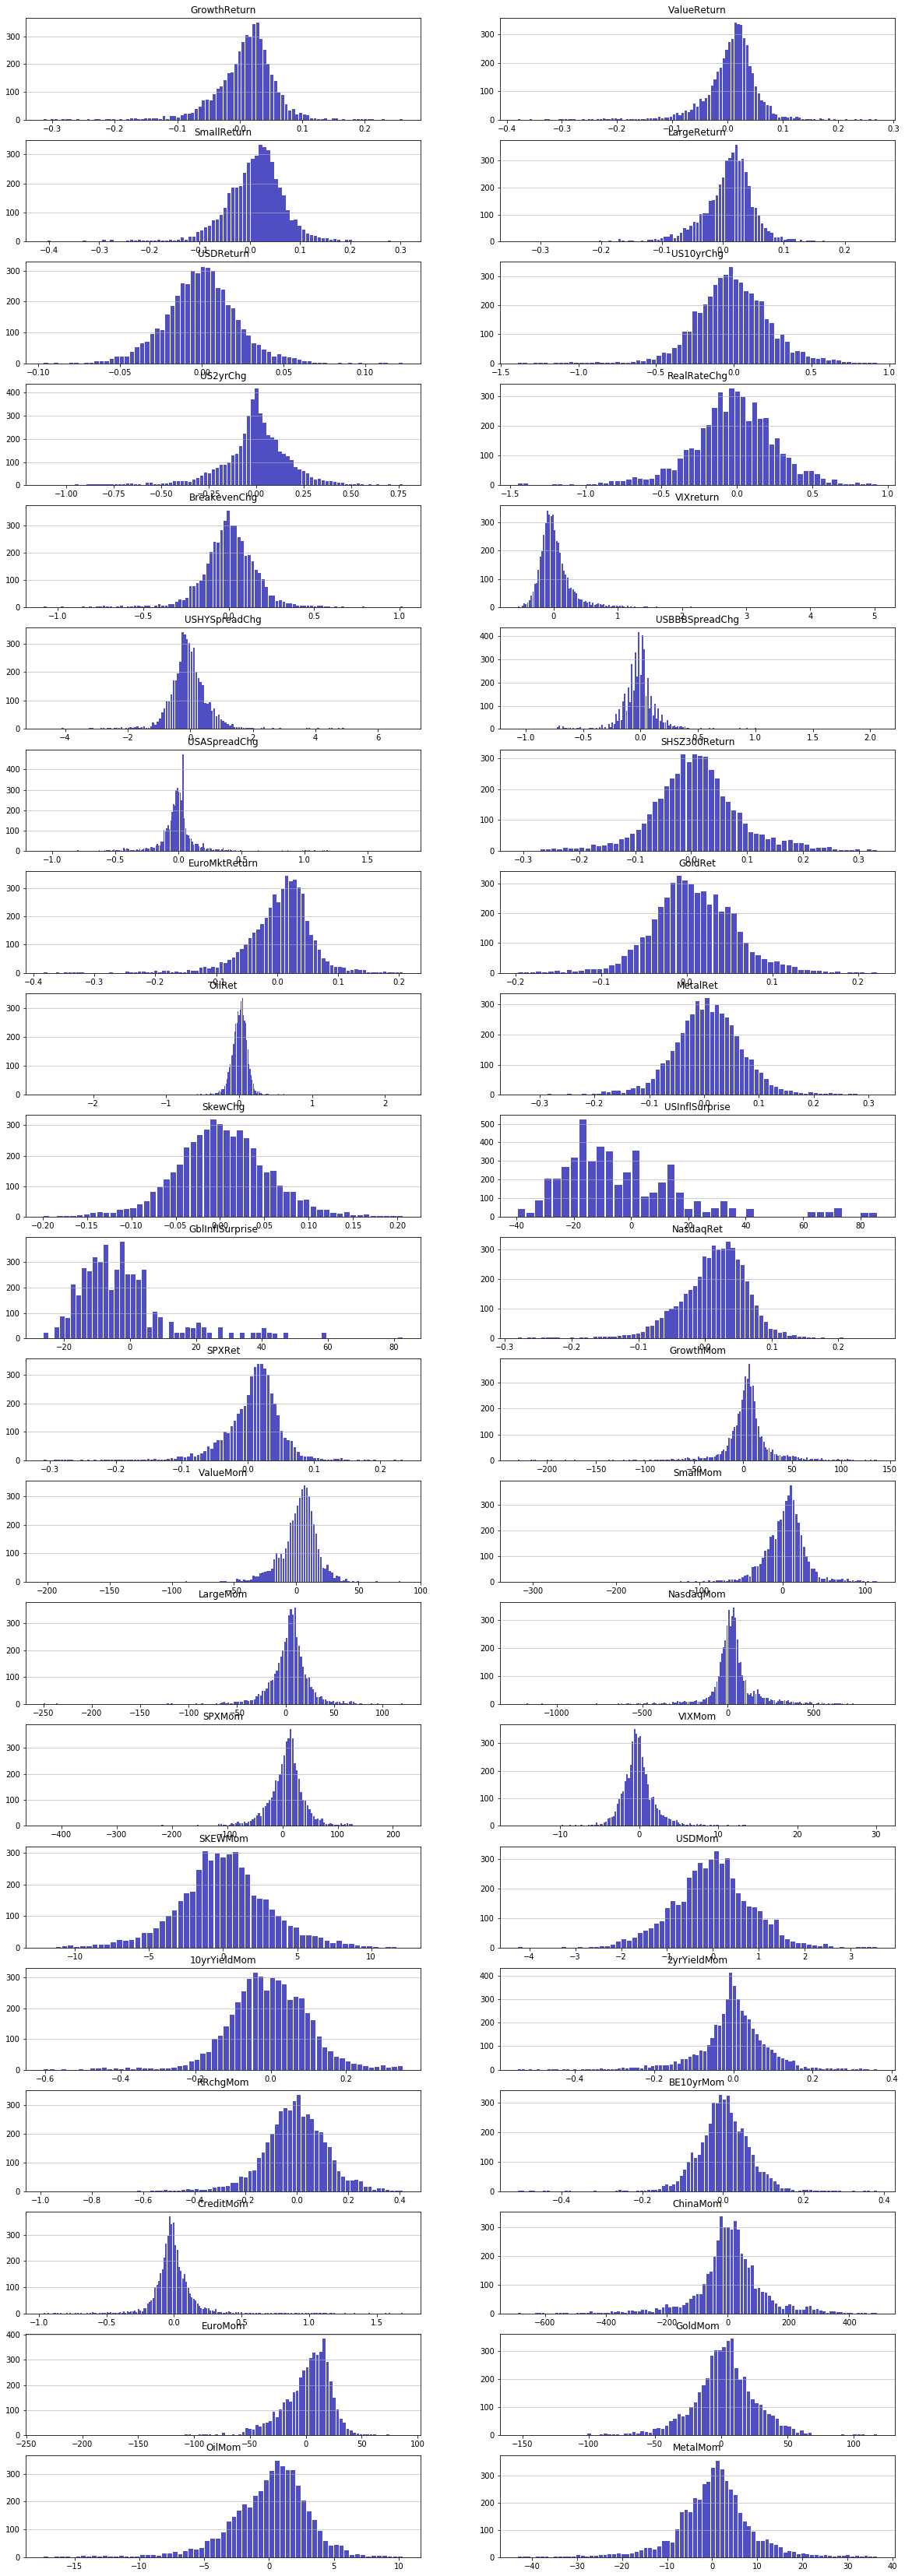

In [16]:
# Now, run univariate analysis
def histograms(df, N, figureSize):

    fig, axs = plt.subplots(math.ceil(N/2), 2, figsize=figureSize)
    axs = axs.ravel()
    for i in range(N):
        axs[i].hist(df.iloc[:,i], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
        axs[i].grid(axis='y', alpha=0.75)
        axs[i].set_title(df.columns[i])

histograms(df.iloc[:,1:], np.shape(df.iloc[:,1:])[1], (20, 60))

In [248]:
df['AvgCorpSpreadChg'] = df[['USHYSpreadChg', 'USBBBSpreadChg', 'USASpreadChg']].mean(axis=1)
df['Target'] = df.iloc[:,1:5].idxmax(axis = 1)

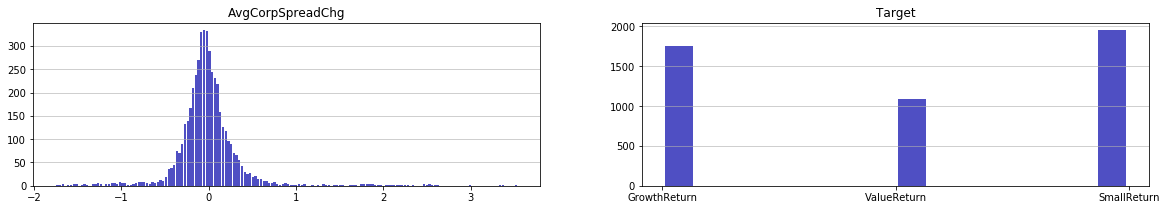

In [249]:
histograms(df.iloc[:,-2:], np.shape(df.iloc[:,-2:])[1], (20, 3))

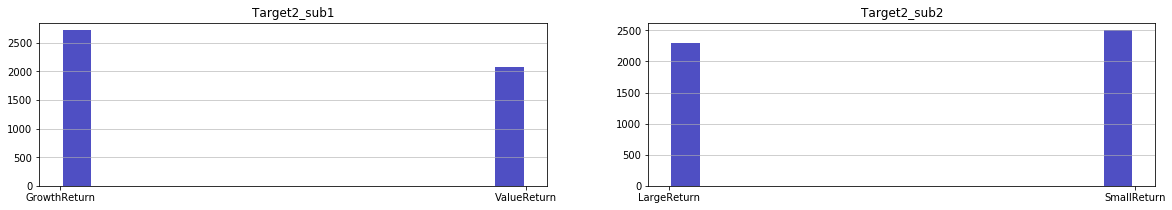

In [250]:
df['Target2_sub1'] = df.iloc[:,1:3].idxmax(axis = 1)
df['Target2_sub2'] = df.iloc[:,3:5].idxmax(axis = 1)
histograms(df.iloc[:,-2:], 2, (20, 3))

In [251]:
df.loc[df['Target2_sub1'] == 'GrowthReturn', 'Target2_sub1'] = "GrowthLead"
df.loc[df['Target2_sub1'] == 'ValueReturn', 'Target2_sub1'] = "ValueLead"

df.loc[df['Target2_sub2'] == 'SmallReturn', 'Target2_sub2'] = "SmallLead"
df.loc[df['Target2_sub2'] == 'LargeReturn', 'Target2_sub2'] = "LargeLead"

df['Target2'] = df['Target2_sub1'] + "," + df['Target2_sub2']

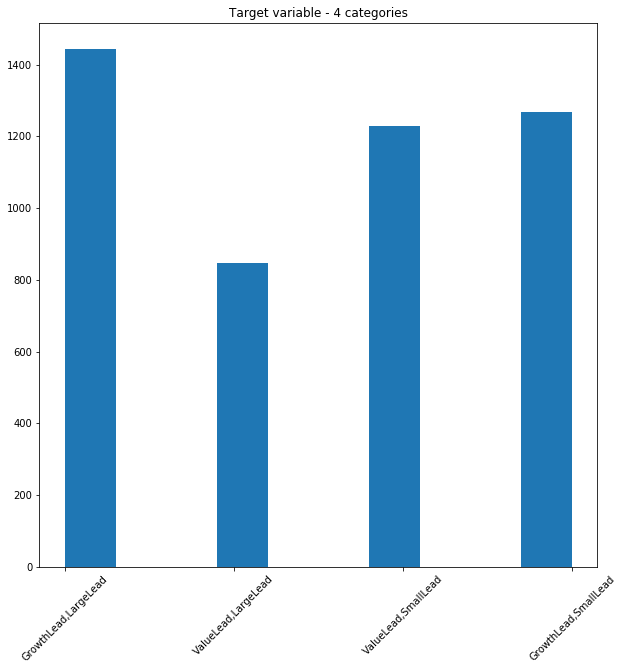

In [252]:
p = plt.hist(df['Target2'])
plt.title('Target variable - 4 categories')
plt.xticks(rotation=45)
plt.show()

## Model Pipeline

In [253]:
def encode_label(label_name, target_var_name):
    label_ref = list(set(label_name))
    for i in range(len(label_ref)):
        df.loc[label_name == label_ref[i], target_var_name] = int(i)
    return df[target_var_name], label_ref


In [254]:
def time_series_cross_val(X):
    ts_cv = TimeSeriesSplit(n_splits = 5, test_size=50)
    splits = list(ts_cv.split(X))
    return splits

In [255]:
# Visualize the trained tree.
def plot_tree(model, train_features, label_ref):
    plt.figure(figsize=(120, 120))
    tree.plot_tree(model, 
                   filled=True, rounded=True, 
                   feature_names = train_features.columns,class_names=label_ref,
                   fontsize=12)
    plt.show()

In [256]:
def parameter_search(X, y, splits, model_type, params, show_feature_imp):
    # Create a dictionary combination of the parameter grid
    parameter_names = list(params.keys())
    v = params.values()
    parameters = list(itertools.product(*v))
    result={}
    for p in parameters:
        if model_type == "dt":
            clf = DecisionTreeClassifier(max_depth = p[0], criterion='entropy', min_samples_leaf=p[1],
                                         min_samples_split = p[2])
        elif model_type == "xgb":
            clf = XGBClassifier(objective = "binary:logistic", 
                                colsample_bytree=p[0], 
                                learning_rate=p[1],
                                max_depth=p[2],
                                alpha=p[3],
                                use_label_encoder=False,
                                eval_metric = 'logloss'
                               )
            
        elif model_type == "lr":
#             clf = LogisticRegression(penalty = 'elasticnet', C = p[0], solver = "saga", 
#                                      max_iter = 200, l1_ratio = p[1], tol = 0.005)
            clf = LogisticRegression(penalty = 'l2', C = p[0], solver = "liblinear", 
                                     max_iter = 200, tol = 0.001)
        
        accuracies = []
        for train_index, test_index in splits:
            X_train = X.loc[train_index,:]
            X_test = X.loc[test_index,:]
            y_train = y.loc[train_index]
            y_test = y.loc[test_index]
            clf.fit(X_train, y_train)
            clf_preds = clf.predict(X_test)
            # evaluate predictions
            accuracies.append(accuracy_score(y_test, clf_preds))
            result[p] = sum(accuracies)/len(accuracies)
        #print(accuracies)
        best_param = max(result, key=result.get)
    
    # get importance
    if show_feature_imp and model_type == "xgb":
        clf = XGBClassifier(objective = "binary:logistic", 
                            colsample_bytree=best_param[0], 
                            learning_rate=best_param[1],
                            max_depth=best_param[2],
                            alpha=best_param[3],
                            use_label_encoder=False,
                            eval_metric = 'logloss'
                           )
        train_index, test_index = splits[-1]
        clf.fit(X.loc[train_index,:], y.loc[train_index])
        plt.rcParams["figure.figsize"] = (10, 10)
        plot_importance(clf)
        plt.show()
        feat_importances = clf.feature_importances_
        #print(clf.get_score(importance_type='weight'))
    elif show_feature_imp and model_type == "dt":
        clf = DecisionTreeClassifier(max_depth = best_param[0], criterion='entropy', min_samples_leaf=best_param[1],
                                     min_samples_split = best_param[2])
        train_index, test_index = splits[-1]
        clf.fit(X.loc[train_index,:], y.loc[train_index])
        feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
        feat_importances.nlargest(30).plot(kind='barh', figsize=(10,10))
        
    elif show_feature_imp and model_type == "lr":
        # get importance
#         clf = LogisticRegression(penalty = 'elasticnet', C = best_param[0], solver = "saga", 
#                                  max_iter = 200, l1_ratio = best_param[1], tol = 0.005)
        clf = LogisticRegression(penalty = 'l2', C = best_param[0], solver = "liblinear", 
                                     max_iter = 200, tol = 0.001)
        train_index, test_index = splits[-1]
        clf.fit(X.loc[train_index,:], y.loc[train_index])
        feat_importances = pd.Series(clf.coef_[0], index=X.columns)
        feat_importances.nlargest(30).plot(kind='barh', figsize=(10,10))
        
    return (best_param, result[best_param], feat_importances)

## Model & feature selection

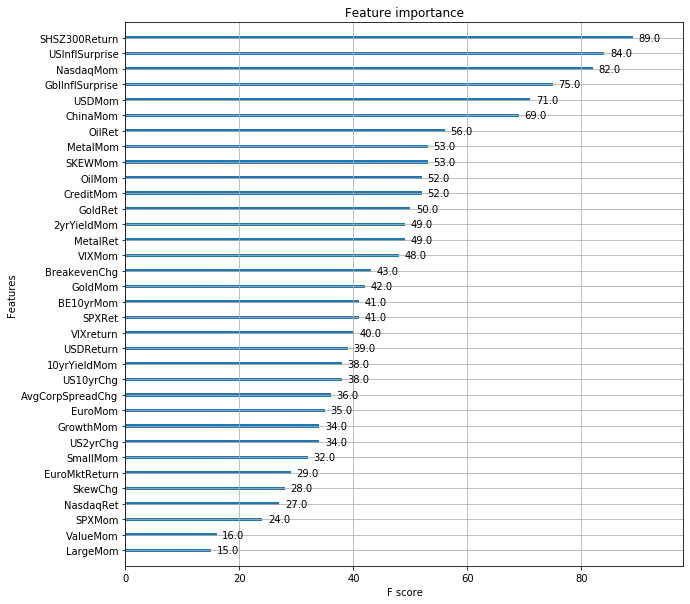

Best parameters: (0.5, 1.0, 10, 10) , accuracy: 0.6719999999999999


In [257]:
#Round 1
#labels, label_ref = encode_label(df['Target2'], 'Target2_num')

#Round 2
test_params = {'colsample_bytree': [0.3,0.5, 0.7, 1.0],
               'learning_rate': [0.01, 0.1, 1.0],
               'max_depth': [5,7,10], 
               'alpha': [0.1, 1.0, 10, 100]
              }

features_names = ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','SPXRet','GrowthMom', 'ValueMom','SmallMom','LargeMom',
                  'NasdaqMom', 'SPXMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']

df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

# Growth vs value
labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)
# top10_GVfeatures = feat_importances.nlargest(10).index.tolist()
# top15_GVfeatures = feat_importances.nlargest(15).index.tolist()
# top20_GVfeatures = feat_importances.nlargest(20).index.tolist()


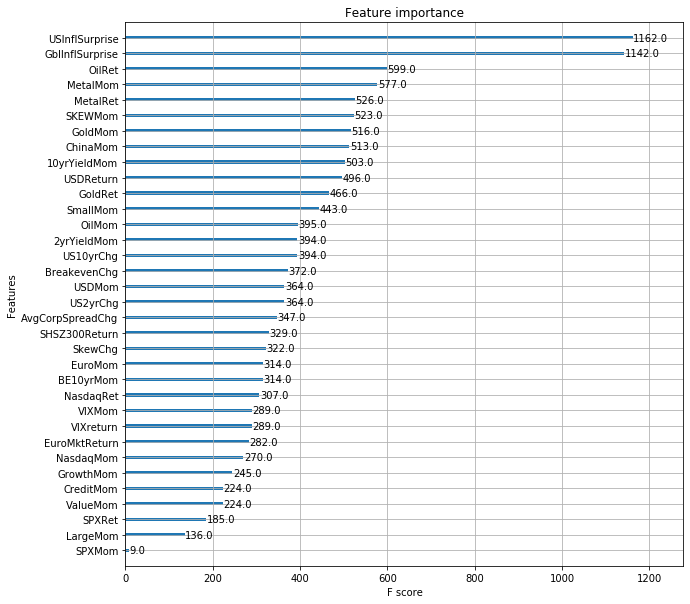

Best parameters: (1.0, 0.01, 10, 1.0) , accuracy: 0.6679999999999999


In [258]:
# Large vs small
labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

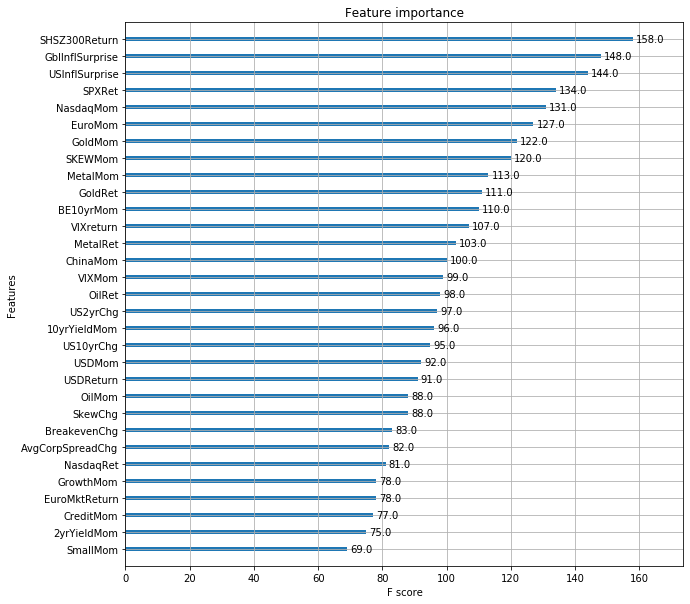

Best parameters: (0.3, 1.0, 7, 0.1) , accuracy: 0.656


In [262]:
#Round 3 - top 10 features
test_params = {'colsample_bytree': [0.3,0.7, 1.0],
               'learning_rate': [0.01, 0.1, 1.0],
               'max_depth': [5,7,10], 
               'alpha': [0.05, 0.1, 1.0, 5.0]}
features_names = ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','SPXRet','GrowthMom','SmallMom',
                  'NasdaqMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']
df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)


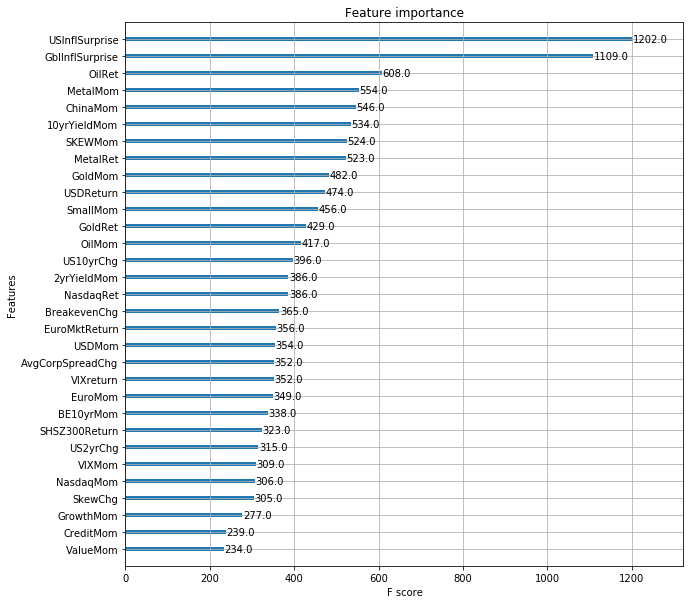

Best parameters: (1.0, 0.01, 10, 1.0) , accuracy: 0.648


In [263]:
features_names =  ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','GrowthMom', 'ValueMom','SmallMom',
                  'NasdaqMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']
df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

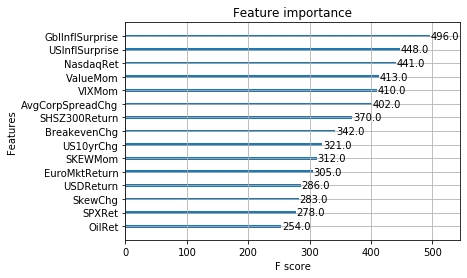

Best parameters: (0.3, 0.1, 7, 5.0) , accuracy: 0.924


In [75]:
#Round 4 - top 15 features
features_names = ['NasdaqRet', 'ValueMom','SkewChg', 'SHSZ300Return', 'AvgCorpSpreadChg',
                  'SKEWMom', 'USDReturn', 'EuroMktReturn', 'USInflSurprise', 'OilRet',
                  'VIXMom', 'US10yrChg', 'BreakevenChg', 'GblInflSurprise', 'SPXRet']

df_features = df[features_names].shift(1)
df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

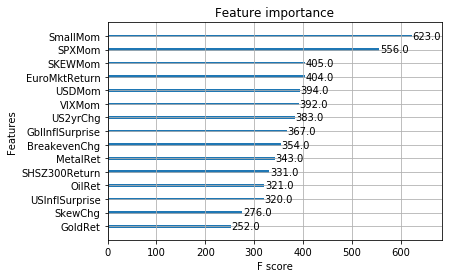

Best parameters: (1.0, 0.1, 7, 5.0) , accuracy: 0.8559999999999999


In [76]:
features_names = ['SmallMom', 'SPXMom','SHSZ300Return', 'US2yrChg', 'USDMom',
                  'SKEWMom', 'GblInflSurprise','MetalRet','VIXMom','OilRet',
                  'EuroMktReturn', 'SkewChg', 'GoldRet','BreakevenChg', 'USInflSurprise']


df_features = df[features_names].shift(1)
df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

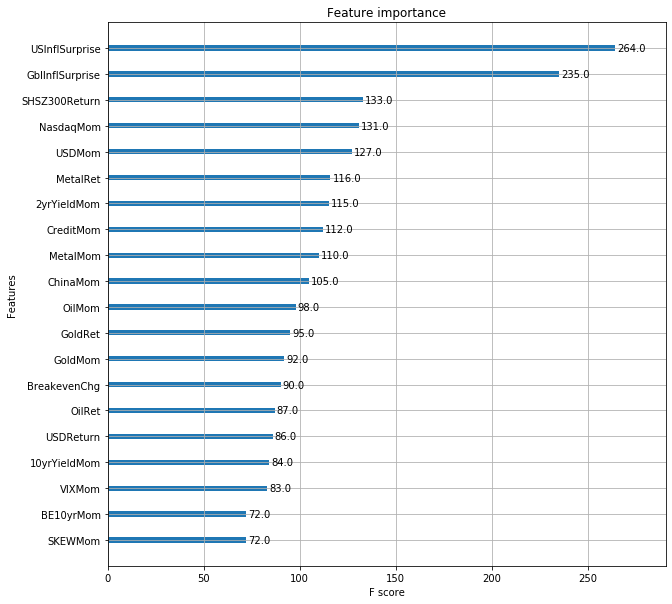

Best parameters: (0.3, 0.1, 5, 1.0) , accuracy: 0.604


In [264]:
#Round 5 - top 20 features
features_names = ['SHSZ300Return', 'USInflSurprise', 'NasdaqMom', 'GblInflSurprise', 'USDMom', 
                  'ChinaMom', 'OilRet', 'MetalMom', 'SKEWMom', 'OilMom', 
                  'CreditMom', 'GoldRet',  '2yrYieldMom', 'MetalRet','VIXMom',
                  'BreakevenChg', 'GoldMom', 'BE10yrMom', '10yrYieldMom', 'USDReturn']

df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

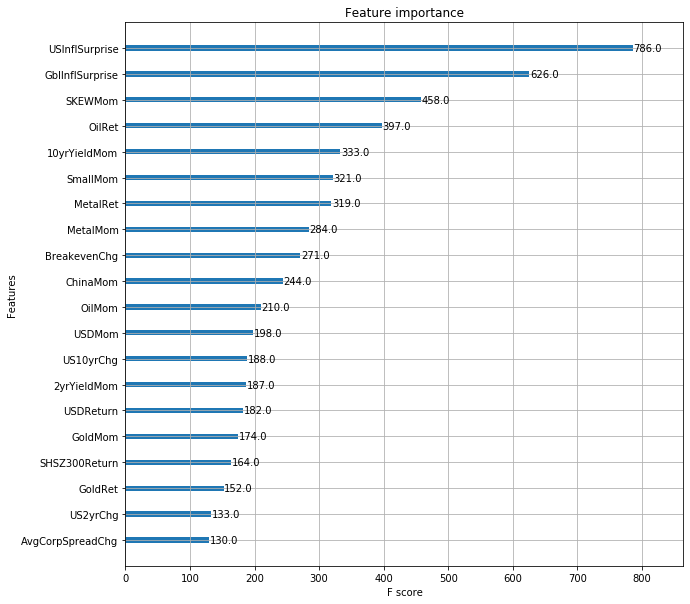

Best parameters: (1.0, 0.01, 7, 0.05) , accuracy: 0.624


In [265]:
features_names = ['USInflSurprise', 'GblInflSurprise', 'OilRet', 'MetalMom', 'MetalRet',
                 'SKEWMom', 'GoldMom', 'ChinaMom', '10yrYieldMom', 'USDReturn',
                 'GoldRet', 'SmallMom', 'OilMom', '2yrYieldMom', 'US10yrChg',
                 'BreakevenChg', 'USDMom', 'US2yrChg', 'AvgCorpSpreadChg', 'SHSZ300Return']
df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'xgb', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

Best parameters: (1.0,) , accuracy: 0.592
['BreakevenChg', '2yrYieldMom', 'GoldRet', 'NasdaqRet', 'SkewChg', 'SPXRet', 'BE10yrMom', 'SHSZ300Return', 'VIXreturn', 'EuroMktReturn', 'OilRet', 'LargeMom', 'AvgCorpSpreadChg', 'USDMom', 'VIXMom', 'US10yrChg', 'GblInflSurprise', 'EuroMom', 'SKEWMom', 'GoldMom']


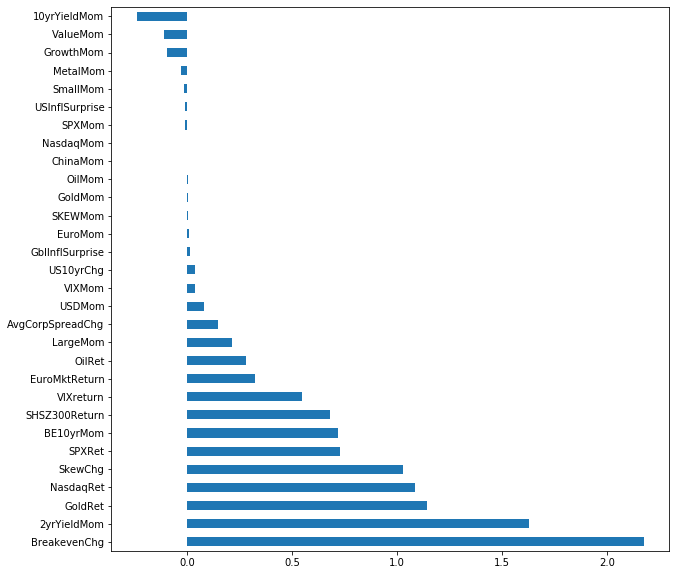

In [266]:
#Round 1 Logistic Reg - Elastic Net
test_params = {'C': [0.001, 0.01, 0.5, 1.0, 2.0, 5.0]#,
              #'l1_ratio': [0, 0.2, 0.5, 0.8, 1.0]
              }
features_names = ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','SPXRet','GrowthMom', 'ValueMom','SmallMom','LargeMom',
                  'NasdaqMom', 'SPXMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']
df_features = df[features_names]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

# Growth vs value
labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)
top10_GVfeatures = feat_importances.nlargest(10).index.tolist()
top15_GVfeatures = feat_importances.nlargest(15).index.tolist()
top20_GVfeatures = feat_importances.nlargest(20).index.tolist()
print(top20_GVfeatures)

Best parameters: (0.001,) , accuracy: 0.5
['VIXMom', 'USDMom', 'SKEWMom', 'SPXMom', 'BreakevenChg', 'GrowthMom', 'ValueMom', 'GblInflSurprise', 'BE10yrMom', 'US10yrChg', 'GoldMom', '10yrYieldMom', 'OilRet', 'GoldRet', 'SHSZ300Return', 'SmallMom', '2yrYieldMom', 'SkewChg', 'VIXreturn', 'USDReturn']


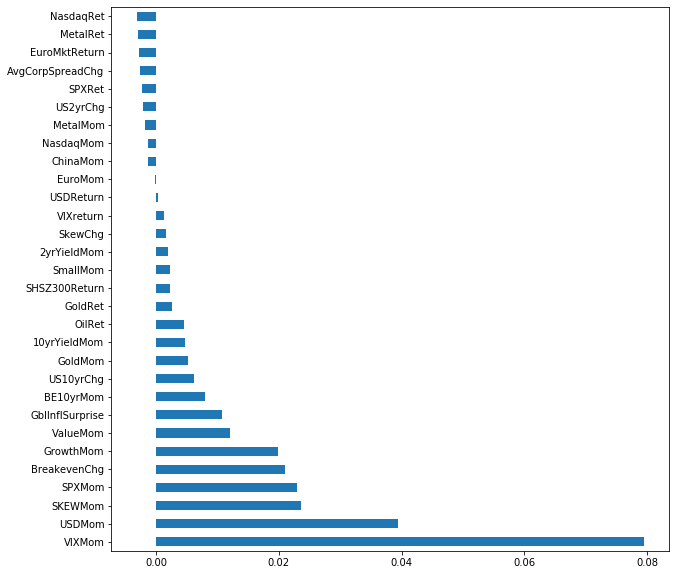

In [267]:
# Large vs small
labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)
top10_LSfeatures = feat_importances.nlargest(10).index.tolist()
top15_LSfeatures = feat_importances.nlargest(15).index.tolist()
top20_LSfeatures = feat_importances.nlargest(20).index.tolist()
print(top20_LSfeatures)

Best parameters: (0.001,) , accuracy: 0.5120000000000001


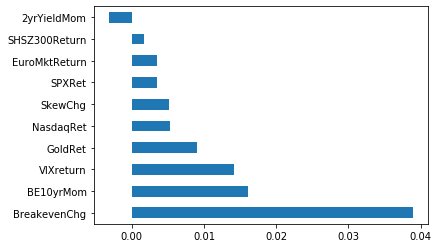

In [89]:
#Round 2 Logistic Reg - Elastic Net
# test_params = {'C': [0.001, 0.01, 0.5, 1.0, 2.0, 5.0],
#               'l1_ratio': [0, 0.2, 0.5, 0.8, 1.0]}

df_features = df[top10_GVfeatures]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

# Growth vs value
labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

Best parameters: (2.0,) , accuracy: 0.4720000000000001


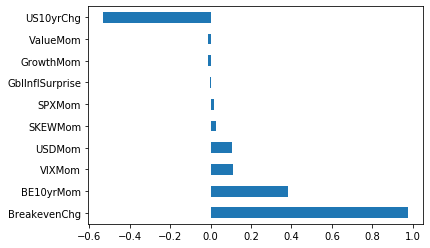

In [91]:
df_features = df[top10_LSfeatures]#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

# Large vs small
labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
#labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

Best parameters: (0.01,) , accuracy: 0.5399999999999999


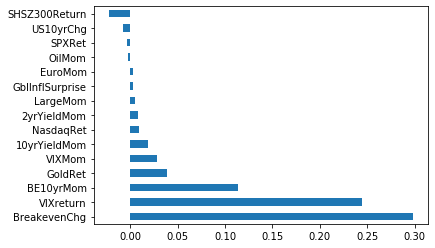

In [62]:
#Round 3 Logistic Reg - L2

df_features = df[top15_GVfeatures].shift(1)
df_features = df_features[1:].reset_index(drop=True)

# Growth vs value
labels, label_refs = encode_label(df['Target2_sub1'], 'Target2_num1')
labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

Best parameters: (2.0,) , accuracy: 0.496


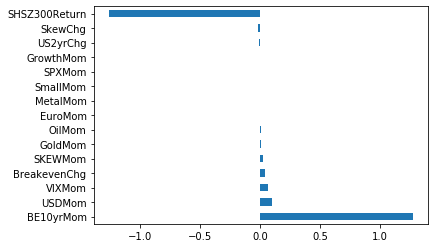

In [63]:
df_features = df[top15_LSfeatures].shift(1)
df_features = df_features[1:].reset_index(drop=True)

# Large vs small
labels, label_refs = encode_label(df['Target2_sub2'], 'Target2_num2')
labels = labels[1:].reset_index(drop=True)

splits = time_series_cross_val(df_features)
best_param, accuracy, feat_importances = parameter_search(df_features, labels, splits, 'lr', test_params, True)
print("Best parameters:", best_param, ", accuracy:", accuracy)

## Simulation

In [268]:
# re-train with best parameters and top features

GVfeatures = ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','SPXRet','GrowthMom', 'ValueMom','SmallMom','LargeMom',
                  'NasdaqMom', 'SPXMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']

# ['NasdaqRet', 'ValueMom','SkewChg', 'SHSZ300Return', 'AvgCorpSpreadChg',
#                   'SKEWMom', 'USDReturn', 'EuroMktReturn', 'USInflSurprise', 'OilRet']
# 
SLfeatures = ['USDReturn', 'US10yrChg','US2yrChg', 'BreakevenChg','VIXreturn', 'AvgCorpSpreadChg',
                  'SHSZ300Return','EuroMktReturn', 'GoldRet', 'OilRet','MetalRet', 'SkewChg', 'USInflSurprise', 
                  'GblInflSurprise','NasdaqRet','GrowthMom', 'ValueMom','SmallMom',
                  'NasdaqMom', 'VIXMom','SKEWMom', 'USDMom', '10yrYieldMom', '2yrYieldMom',
                 'BE10yrMom', 'CreditMom','ChinaMom','EuroMom', 'GoldMom', 'OilMom','MetalMom']
# ['SmallMom', 'SPXMom','SHSZ300Return', 'US2yrChg', 'USDMom',
#                   'SKEWMom', 'GblInflSurprise','MetalRet','VIXMom','OilRet']
# 

df_features = df.drop(['Dates', 'Target2_num1', 'Target2_num2'], axis=1)#.shift(1)
#df_features = df_features[1:].reset_index(drop=True)

labelsGV, label_refsGV = encode_label(df['Target2_sub1'], 'Target2_num1')
#labelsGV = labelsGV[1:].reset_index(drop=True)
labelsSL, label_refsSL = encode_label(df['Target2_sub2'], 'Target2_num2')
#labelsSL = labelsSL[1:].reset_index(drop=True)

df_sim = pd.concat([df['Dates'], df_features, labelsGV, labelsSL], axis=1) #[1:].reset_index(drop=True)
df_train = df_sim[df_sim['Dates']<='2018-12-30']
df_test = df_sim[df_sim['Dates']>'2018-12-30']
df_train.describe()


,GrowthReturn,ValueReturn,SmallReturn,LargeReturn,USDReturn,US10yrChg,US2yrChg,RealRateChg,BreakevenChg,VIXreturn,...,BE10yrMom,CreditMom,ChinaMom,EuroMom,GoldMom,OilMom,MetalMom,AvgCorpSpreadChg,Target2_num1,Target2_num2
count,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,...,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,0.007768,0.005738,0.008566,0.006764,-0.000095,-0.005755,0.004437,-0.007072,0.001171,0.025186,...,0.000396,-0.003038,3.918935,0.646808,1.813816,0.036497,0.260970,-0.007831,0.545567,0.459151
std,0.043331,0.045394,0.057455,0.043387,0.022996,0.244478,0.197082,0.264623,0.163402,0.259738,...,0.072464,0.154720,114.397710,20.913188,24.121365,2.940453,8.889337,0.359141,0.497981,0.498390
min,-0.314014,-0.303230,-0.363779,-0.308675,-0.096873,-1.392600,-1.119600,-1.160000,-1.076000,-0.562463,...,-0.507579,-0.964825,-690.577048,-108.277619,-153.632762,-17.394667,-43.203981,-1.713333,0.000000,0.000000
25%,-0.013048,-0.013825,-0.022347,-0.012791,-0.014630,-0.150800,-0.079800,-0.160000,-0.079000,-0.122311,...,-0.035681,-0.065206,-37.702619,-10.418238,-9.770048,-1.603429,-4.037995,-0.153333,0.000000,0.000000
50%,0.013157,0.011362,0.014418,0.012268,-0.000222,-0.015000,0.009600,-0.010000,-0.001200,-0.022804,...,-0.000712,-0.014698,5.681619,4.465905,2.369810,0.346286,0.561898,-0.030000,1.000000,0.000000
75%,0.033006,0.030891,0.042445,0.031520,0.013892,0.144800,0.108550,0.150000,0.085300,0.105713,...,0.037833,0.050397,52.057429,15.211714,14.925667,1.917667,4.712257,0.110000,1.000000,1.000000
max,0.209909,0.270442,0.305294,0.237374,0.123283,0.924800,0.774700,0.930000,1.020300,3.047722,...,0.382708,1.188095,458.039429,61.240857,114.746000,10.348286,36.636648,2.623333,1.000000,1.000000


In [269]:
df_train.head()

,Dates,GrowthReturn,ValueReturn,SmallReturn,LargeReturn,USDReturn,US10yrChg,US2yrChg,RealRateChg,BreakevenChg,...,GoldMom,OilMom,MetalMom,AvgCorpSpreadChg,Target,Target2_sub1,Target2_sub2,Target2,Target2_num1,Target2_num2
0,2002-12-31,-0.024978,-0.026020,-0.028507,-0.025493,-0.013941,-0.1182,-0.1279,-0.12,-0.0554,...,12.363333,2.556667,-2.000619,0.076667,GrowthReturn,GrowthLead,LargeLead,"GrowthLead,LargeLead",1.0,1.0
1,2003-01-02,-0.053771,-0.050033,-0.056850,-0.051932,-0.031870,-0.1708,-0.2661,-0.16,-0.0115,...,10.920476,2.313143,-1.800752,-0.100000,ValueReturn,ValueLead,LargeLead,"ValueLead,LargeLead",0.0,1.0
2,2003-01-03,-0.066721,-0.062002,-0.055297,-0.064398,-0.034577,-0.1337,-0.2339,-0.13,0.0259,...,9.788095,2.155905,-1.487533,-0.130000,SmallReturn,ValueLead,SmallLead,"ValueLead,SmallLead",0.0,0.0
3,2003-01-06,-0.086239,-0.093857,-0.075553,-0.090020,-0.038926,-0.0852,-0.1774,-0.08,-0.0136,...,8.802381,1.775238,-1.090238,-0.216667,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0
4,2003-01-07,-0.086682,-0.092591,-0.074131,-0.089601,-0.026481,-0.0774,-0.1205,-0.08,-0.0134,...,8.446190,1.536762,-0.561829,-0.233333,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0


In [270]:
df_test.head()

,Dates,GrowthReturn,ValueReturn,SmallReturn,LargeReturn,USDReturn,US10yrChg,US2yrChg,RealRateChg,BreakevenChg,...,GoldMom,OilMom,MetalMom,AvgCorpSpreadChg,Target,Target2_sub1,Target2_sub2,Target2,Target2_num1,Target2_num2
4027,2018-12-31,0.089321,0.075665,0.111868,0.082422,-0.006251,-0.3456,-0.3208,-0.31,-0.2740,...,25.252571,-4.187143,-5.215437,0.443333,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0
4028,2019-01-02,0.088514,0.078317,0.107786,0.083364,-0.004657,-0.3675,-0.3189,-0.30,-0.2801,...,25.451333,-3.151333,-5.716254,0.440000,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0
4029,2019-01-03,0.135541,0.100603,0.140292,0.117768,-0.007574,-0.4162,-0.4425,-0.39,-0.2838,...,27.366952,-2.794476,-6.539166,0.463333,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0
4030,2019-01-04,0.100587,0.071280,0.101016,0.085748,-0.008106,-0.2459,-0.3010,-0.22,-0.1811,...,26.797810,-1.886857,-5.884970,0.310000,SmallReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0
4031,2019-01-07,0.085576,0.064338,0.080161,0.074852,-0.011817,-0.1995,-0.2194,-0.18,-0.1284,...,26.084952,-1.023619,-5.026362,0.150000,GrowthReturn,GrowthLead,SmallLead,"GrowthLead,SmallLead",1.0,0.0


In [271]:
df_train['Target2_num1'].head()

0    1.0
1    0.0
2    0.0
3    1.0
4    1.0
Name: Target2_num1, dtype: float64

In [272]:
# predicted probability Growth vs Value
test_21day = df_test.iloc[::21]
best_param = [0.5, 1.0, 10, 10]
clf = XGBClassifier(objective = "binary:logistic", 
                                colsample_bytree=best_param[0], 
                                learning_rate=best_param[1],
                                max_depth=best_param[2],
                                alpha=best_param[3],
                                use_label_encoder=False,
                                eval_metric = 'logloss'
                               )
clf.fit(df_train[GVfeatures], df_train['Target2_num1'])
predsGV = clf.predict(test_21day[GVfeatures])
# best_param = [5.0]
# clf = LogisticRegression(penalty = 'l2', C = best_param[0], solver = "liblinear", 
#                          max_iter = 200, tol = 0.001)
# clf.fit(df_train[top15_GVfeatures], df_train['Target2_num1'])
# predsGV = clf.predict(test_21day[top15_GVfeatures])

print(predsGV)
print("accuracy:", accuracy_score(test_21day['Target2_num1'], predsGV))
pred_probGV = clf.predict_proba(test_21day[GVfeatures])
print("0:", label_refsGV[0], ", 1:", label_refsGV[1])

[1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1]
accuracy: 0.5135135135135135
0: ValueLead , 1: GrowthLead


In [273]:
# predicted probability Small Cap vs Large Cap
best_param = [1.0, 0.01, 7, 0.1]
clf = XGBClassifier(objective = "binary:logistic", 
                                colsample_bytree=best_param[0], 
                                learning_rate=best_param[1],
                                max_depth=best_param[2],
                                alpha=best_param[3],
                                use_label_encoder=False,
                                eval_metric = 'logloss'
                               )
clf.fit(df_train[SLfeatures], df_train['Target2_num2'])
predsSL = clf.predict(test_21day[SLfeatures])

# best_param = [0.001]
# clf = LogisticRegression(penalty = 'l2', C = best_param[0], solver = "liblinear", 
#                          max_iter = 200, tol = 0.001)
# clf.fit(df_train[top15_LSfeatures], df_train['Target2_num1'])
# predsSL = clf.predict(test_21day[top15_LSfeatures])

print(predsSL)
print("accuracy:", accuracy_score(test_21day['Target2_num2'], predsSL))
pred_probSL = clf.predict_proba(test_21day[SLfeatures])
print("0:", label_refsSL[0], ", 1:", label_refsSL[1])

[0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
accuracy: 0.4594594594594595
0: SmallLead , 1: LargeLead


In [171]:
pd.concat([pd.DataFrame(test_21day['Dates']).reset_index(drop=True), 
           pd.DataFrame(pred_probGV).reset_index(drop=True), 
           pd.DataFrame(np.array(predsGV)).reset_index(drop=True),
           pd.DataFrame(pred_probSL).reset_index(drop=True), 
           pd.DataFrame(np.array(predsSL)).reset_index(drop=True)],
          axis=1).to_csv("test_21day5.csv", header = ['Date', 'Value_pred_prob', 'Growth_pred_prob', 
                                                     'GVbinary', 'Large_pred_prob', 'Small_pred_prob',
                                                     'LSbinary'])
